<a href="https://colab.research.google.com/github/Uros-Males/Minimization_Problem_On_Identical_Machines_Analysis/blob/main/NEWNEW_MIXED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#IN PROGRESS....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import time
import keras


df = pd.read_csv('/content/sample_data/C-instances-runtime-analysis.csv')



df = df[df['n/m']==2]

shuffled = df.sample(frac=1).reset_index()

columns_dont_want = [ 'index', 'inst.name','type', 'CPLEXStatus'] #cple
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
names = ['indeks', 'n', 'n/m', '(n/m)^2', '(n/m)^3', 'm/n', 'av.length', 'std.dev', 'median', 'range', 'min', 'max', 'k']

In [2]:
y_new = []
cnt0=0
cnt1=0
cnt2=0
cnt3=0
for val in y:
  if(val<10):
    y_new.append(0)
    cnt0+=1
  elif(10 <= val and val<1000):
    y_new.append(1)
    cnt1+=1
  else:
    y_new.append(2)
    cnt2+=1

cnt = 0
if(cnt0>0):
  cnt+=1
if(cnt1>0):
  cnt+=1
if(cnt2>0):
  cnt+=1
if(cnt3>0):
  cnt+=1

shuffled['y_new'] = y_new
y_encoded = shuffled.loc[:,'y_new']
y_new = np.array(y_new)

In [3]:
names = [ 'av.length', 'n', 'std.dev', 'k', 'm', 'max']
X_modified = X.drop([   'n/m', 'indeks', 'class',  'subtype', '(m/n)^3', '(m/n)^2', '(n/m)^2', '(n/m)^3','m/n','median', 'min', 'range'], axis = 1)
print(X_modified.head())
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(random_state=0)
X_modified, y_encoded = oversample.fit_resample(X_modified, y_encoded)


     n   m   av.length     std.dev  max   k          y
0   40  20   90.125000   39.289970  197  36   0.088831
1  160  80   52.162498   29.158621  100  84  27.108606
2  120  60   98.966667   46.259216  219  83   0.893041
3  100  50  391.859985  107.570328  645  92   1.374334
4  180  90   50.038887   29.228119  100  81  31.764862


In [4]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

l_encode = LabelEncoder()
l_encode.fit(y_encoded)
y_encoded = l_encode.transform(y_encoded)
y_encoded = to_categorical(y_encoded)
y_encoded

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [5]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()


X_train, X_test, y_train, y_test = train_test_split(X_modified, y_encoded, random_state=0, train_size = 0.9)
print(X_train.shape[0])
print(X_test.shape[0])

X_train = X_train.drop(['y', 'k', 'm'], axis = 1)

X_train = sc.fit_transform(X_train)
X_test_copy = X_test
print(X_test_copy.head())
X_test = X_test.drop(['y', 'k', 'm'], axis = 1)
X_test = sc.transform(X_test)

1374
153
        n    m   av.length    std.dev  max    k             y
1362  180   90  101.466667  50.076527  257  112  99999.000000
511    20   10   74.550003  13.343538   98   17      0.054215
9      60   30   45.433334  29.867712   99   46      0.452781
393   200  100  104.050003  48.025402  247  120      1.962976
471   140   70   59.092857  22.890703  100   67     11.441329


In [6]:

from keras.models import Sequential
from keras.layers import Dense, Dropout

classifier = Sequential()
classifier.add(Dense(8, input_dim = X_modified.shape[1]-3, activation='relu'))

classifier.add(Dense(12, activation = 'relu'))
classifier.add(Dropout(0.125))

#classifier.add(Dense(32, activation = 'relu'))

#classifier.add(Dense(32, activation = 'relu'))
#classifier.add(Dense(32, activation = 'relu'))
#classifier.add(Dense(16, activation = 'relu'))

#classifier.add(Dense(16, activation='relu'))

#classifier.add(Dense(8, activation='relu'))

#classifier.add(Dense(12, activation='relu'))

classifier.add(Dense(cnt, activation = 'softmax'))
classifier.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 40        
                                                                 
 dense_1 (Dense)             (None, 12)                108       
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 39        
                                                                 
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________


In [7]:
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 25, 
                                        restore_best_weights = True)
  
history = classifier.fit(X_train, y_train, batch_size = 64, 
                    epochs = 350, shuffle = True)

Epoch 1/350
22/22 [==============================] - 1s 3ms/step - loss: 1.3417 - accuracy: 0.3093
Epoch 2/350
22/22 [==============================] - 0s 4ms/step - loss: 1.2349 - accuracy: 0.3552
Epoch 3/350
22/22 [==============================] - 0s 5ms/step - loss: 1.1544 - accuracy: 0.3785
Epoch 4/350
22/22 [==============================] - 0s 4ms/step - loss: 1.0904 - accuracy: 0.4163
Epoch 5/350
22/22 [==============================] - 0s 3ms/step - loss: 1.0427 - accuracy: 0.5560
Epoch 6/350
22/22 [==============================] - 0s 6ms/step - loss: 1.0087 - accuracy: 0.6143
Epoch 7/350
22/22 [==============================] - 0s 3ms/step - loss: 0.9792 - accuracy: 0.5939
Epoch 8/350
22/22 [==============================] - 0s 3ms/step - loss: 0.9483 - accuracy: 0.5873
Epoch 9/350
22/22 [==============================] - 0s 3ms/step - loss: 0.9151 - accuracy: 0.5932
Epoch 10/350
22/22 [==============================] - 0s 4ms/step - loss: 0.8853 - accuracy: 0.5844
Epoch 11/

accuracy: 92.81%


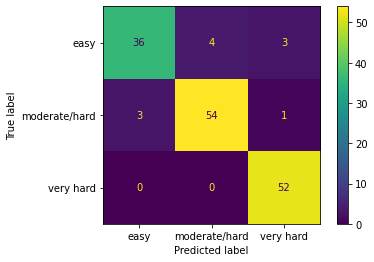

In [8]:
from keras.metrics import accuracy
pred = classifier.predict(X_test)
pred_ = np.argmax(pred, axis = 1)
pred_ = l_encode.inverse_transform(pred_)

true_y = l_encode.inverse_transform(np.argmax(to_categorical(y_test), axis = 1)[:,1])
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(true_y, pred_, labels=[0, 1, 2])
cmd = ConfusionMatrixDisplay(cm, display_labels=['easy','moderate/hard', 'very hard'])
cmd.plot()

cnt = 0
cnt_correct = 0
for i in range(len(pred)):
  cnt += 1
  if(pred_[i] == true_y[i]):
    cnt_correct += 1
print(f'accuracy: {(cnt_correct/cnt)*100:.2f}%')

In [9]:
column_names = ['n', 'k', 'n/m', 'av.length', 'std.dev', 'y']
df_reg = pd.DataFrame(columns = column_names)
print(X_test_copy.shape[0])
print(len(pred))
for i in range(len(pred)):
  if(pred_[i] == 1):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'n/m': 2, 
                  'av.length' : X_test_copy.iloc[i]['av.length'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg = df_reg.append(dictionary, ignore_index = True)
#VM

153
153


In [10]:
column_names = ['n', 'k', 'm', 'std.dev', 'y']
df_reg0 = pd.DataFrame(columns = column_names)
print(X_test_copy.shape[0])
print(len(pred))
for i in range(len(pred)):
  if(pred_[i] == 0):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'max': X_test_copy.iloc[i]['max'],
                  'm' : X_test_copy.iloc[i]['m'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg0 = df_reg0.append(dictionary, ignore_index = True)
#EASY

153
153


In [11]:
column_names = ['n', 'k', 'av.length', 'std.dev', 'm', 'y']
df_reg2 = pd.DataFrame(columns = column_names)
print(X_test_copy.shape[0])
print(len(pred))
for i in range(len(pred)):
  if(pred_[i] == 2):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'm': X_test_copy.iloc[i]['m'],
                  'av.length' : X_test_copy.iloc[i]['av.length'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg2 = df_reg2.append(dictionary, ignore_index = True)

#VHARD

153
153


In [12]:
#IN PROGRESS....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import time
import keras


df = pd.read_csv('/content/sample_data/C-instances-runtime-analysis.csv')




df = df[df['n/m']!=2]

shuffled = df.sample(frac=1).reset_index()

columns_dont_want = [ 'index', 'inst.name','type', 'CPLEXStatus'] 
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
names = ['indeks', 'n', 'n/m', '(n/m)^2', '(n/m)^3', 'm/n', 'av.length', 'std.dev', 'median', 'range', 'min', 'max', 'k']

In [13]:
y_new = []
for val in y:
  if(val<10):
    y_new.append(0)
  elif(10 <= val and val <1000):
    y_new.append(1)
  else:
    y_new.append(2)

shuffled['y_new'] = y_new
y_encoded = shuffled.loc[:,'y_new']
y_new = np.array(y_new)
X_modified = X

In [14]:
from imblearn.over_sampling import RandomOverSampler

names =[ 'std.dev', 'n','n/m', 'max','av.length', 'm', 'k']
X_modified = X.drop([  'median', 'range',  'min','indeks', 'class',  'subtype', '(m/n)^3', '(m/n)^2', '(n/m)^2', '(n/m)^3','m/n'], axis = 1)
X_modified['n/m'] = X_modified['n/m']
#print(X_modified.head())

oversample = RandomOverSampler(random_state=0)
#oversample.fit(X_modified, y_encoded)
X_modified, y_encoded = oversample.fit_resample(X_modified, y_encoded)

In [15]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

l_encode = LabelEncoder()
l_encode.fit(y_encoded)
y_encoded = l_encode.transform(y_encoded)
y_encoded = to_categorical(y_encoded)
y_encoded

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [16]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y_encoded, random_state=0, train_size = 0.9)
print(X_train.shape[0])
print(X_test.shape[0])

X_train = X_train.drop(['y',  'm'], axis = 1)
X_train = sc.fit_transform(X_train)
X_test_copy = X_test
print(X_test_copy.head())
X_test = X_test.drop(['y',  'm'], axis = 1)
X_test = sc.transform(X_test)

12363
1374
         n   m    n/m  av.length    std.dev  max   k           y
3234   120  12  10.00  99.625000  48.803493  259  93  936.622864
4495    54  18   3.00  60.296295  19.712683   98  36    9.853076
10982   18   8   2.25  72.833336  14.669897   94  12    0.108301
9657    36   4   9.00  53.222221  25.083988  100  30    6.223209
5976    18   8   2.25  43.555557  15.534486   63  16    0.241038


In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

classifier = Sequential()
classifier.add(Dense(16, input_dim = X_modified.shape[1]-2, activation='relu'))

classifier.add(Dropout(0.2))

classifier.add(Dense(3, activation = 'softmax'))
classifier.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                112       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 3)                 51        
                                                                 
Total params: 163
Trainable params: 163
Non-trainable params: 0
_________________________________________________________________


In [18]:
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 25, 
                                        restore_best_weights = True)
  
history = classifier.fit(X_train, y_train, batch_size = 32, 
                    epochs = 120)

Epoch 1/120
387/387 [==============================] - 1s 2ms/step - loss: 0.7048 - accuracy: 0.7009
Epoch 2/120
387/387 [==============================] - 1s 2ms/step - loss: 0.4324 - accuracy: 0.8343
Epoch 3/120
387/387 [==============================] - 1s 2ms/step - loss: 0.3900 - accuracy: 0.8454
Epoch 4/120
387/387 [==============================] - 1s 2ms/step - loss: 0.3688 - accuracy: 0.8564
Epoch 5/120
387/387 [==============================] - 1s 2ms/step - loss: 0.3591 - accuracy: 0.8576
Epoch 6/120
387/387 [==============================] - 1s 2ms/step - loss: 0.3537 - accuracy: 0.8606
Epoch 7/120
387/387 [==============================] - 1s 2ms/step - loss: 0.3457 - accuracy: 0.8614
Epoch 8/120
387/387 [==============================] - 1s 2ms/step - loss: 0.3399 - accuracy: 0.8684
Epoch 9/120
387/387 [==============================] - 1s 2ms/step - loss: 0.3331 - accuracy: 0.8724
Epoch 10/120
387/387 [==============================] - 1s 2ms/step - loss: 0.3331 - accura

accuracy: 92.21%


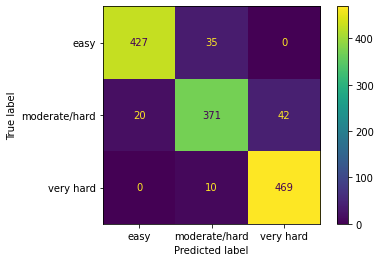

In [19]:
from keras.metrics import accuracy
pred = classifier.predict(X_test)
pred_ = np.argmax(pred, axis = 1)
pred_ = l_encode.inverse_transform(pred_)

true_y = l_encode.inverse_transform(np.argmax(to_categorical(y_test), axis = 1)[:,1])
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_y, pred_, labels=[0, 1, 2])
cmd = ConfusionMatrixDisplay(cm, display_labels=['easy','moderate/hard', 'very hard'])

cmd.plot()

cnt = 0
cnt_correct = 0
for i in range(len(pred)):
  cnt += 1
  if(pred_[i] == true_y[i]):
    cnt_correct += 1
print(f'accuracy: {(cnt_correct/cnt)*100:.2f}%')

In [20]:
for i in range(len(pred)):
  if(pred_[i] == 1):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'n/m': X_test_copy.iloc[i]['n/m'], 
                  'av.length' : X_test_copy.iloc[i]['av.length'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg = df_reg.append(dictionary, ignore_index = True)

for i in range(len(pred)):
  if(pred_[i] == 0):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'max': X_test_copy.iloc[i]['max'],
                  'm' : X_test_copy.iloc[i]['m'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg0 = df_reg0.append(dictionary, ignore_index = True)
#EASY

for i in range(len(pred)):
  if(pred_[i] == 2):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'm': X_test_copy.iloc[i]['m'],
                  'av.length' : X_test_copy.iloc[i]['av.length'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg2 = df_reg2.append(dictionary, ignore_index = True)

#VHARD

In [21]:
print(df_reg.shape[0])
print(df_reg.head(500))

474
         n     k   n/m   av.length    std.dev           y
0    140.0  67.0  2.00   59.092857  22.890703   11.441329
1    160.0  65.0  2.00   60.918751  23.643833   24.906269
2    120.0  66.0  2.00   62.500000  23.460318   11.658648
3    180.0  49.0  2.00   74.266670  14.121420   12.721915
4    160.0  83.0  2.00   50.049999  28.861807   21.955641
..     ...   ...   ...         ...        ...         ...
469  140.0  49.0  5.00   75.857140  13.994639   40.009068
470  200.0  76.0  2.50   59.404999  23.528475   57.029049
471  126.0  83.0  2.25  103.714287  47.162842    1.426909
472   72.0  52.0  9.00   56.416668  22.320173  113.205406
473   90.0  43.0  2.25   73.711113  14.974319    8.357958

[474 rows x 6 columns]


In [22]:
print(df_reg0.head())

       n      k      m    std.dev          y    max
0   20.0   17.0   10.0  13.343538   0.054215   98.0
1   60.0   46.0   30.0  29.867712   0.452781   99.0
2  200.0  120.0  100.0  48.025402   1.962976  247.0
3  140.0   68.0   70.0  19.779930  11.436773  138.0
4   40.0   33.0   20.0  23.155603   1.569403   99.0


In [23]:
print(df_reg2.head())

       n      k   av.length     std.dev     m        y
0  180.0  112.0  101.466667   50.076527  90.0  99999.0
1  100.0   83.0   96.209999   47.907383  50.0  99999.0
2  120.0   93.0   99.625000   48.803493  60.0  99999.0
3  140.0  121.0  547.578552  137.977631  70.0  99999.0
4   40.0   37.0   87.949997   48.465660  20.0  99999.0


In [24]:
for i in range(df_reg2.shape[0]):
  if(df_reg2.iloc[i]['y'] == 99999):
    df_reg2.loc[i, 'y'] = 4510

for i in range(df_reg.shape[0]):
  if(df_reg.iloc[i]['y'] == 99999):
    df_reg.loc[i, 'y'] = 4510

for i in range(df_reg0.shape[0]):
  if(df_reg0.iloc[i]['y'] == 99999):
    df_reg0.loc[i, 'y'] = 4510

print(df_reg['y'].max())
print(df_reg0['y'].max())
print(df_reg2['y'].max())
shuffled = df_reg.sample(frac=1).reset_index()

columns_dont_want = ['y', 'index', 'inst.name','type', 'CPLEXStatus']
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
X_modified = X

yy_final = []
predd_final = []

4510.0
31.403185
4510.0


In [25]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(random_state=0)
X_modified, y = oversample.fit_resample(X_modified, y.astype('int'))
print(X_modified.shape[0])

from imblearn.over_sampling import SMOTE

smote_on_3 = 50
#oversample = SMOTE(sampling_strategy={99999:50000})
#X_modified, y = oversample.fit_resample(X_modified, y)
print(X_modified.shape[0])

tmp = X_modified
tmp['y'] = y
tmp = tmp.sample(frac = 1).reset_index()
print(tmp.head(60))
#y = np.log10(tmp['y']*10)+20
y = tmp['y']
X_modified = tmp.drop(['y'], axis = 1)

2189
2189
    index      n      k    n/m   av.length     std.dev     y
0    1351   72.0   56.0   6.00  106.263885   42.463898   148
1    1994  198.0   75.0   6.00   59.979797   23.100740   616
2    1015   54.0   41.0   6.00   99.222221   18.143732    85
3     846  198.0   85.0   4.50   50.696968   28.879566    65
4    1386   72.0   41.0   9.00   78.611115   14.876538   162
5     182  126.0   95.0   4.50  103.984123   48.371731   418
6    1223  220.0   51.0   2.75   76.859093   14.593524   125
7    1842  110.0   96.0   2.75  415.172729  109.918373   384
8    1208   44.0   28.0  11.00   76.954544   15.064134   121
9     919  162.0   78.0   6.00   51.413582   28.984388    74
10   1743   72.0   46.0   9.00   53.972221   29.060879   318
11   1324  198.0   77.0   6.00   58.585857   23.449919   143
12    201  120.0   93.0   2.50   99.625000   48.803493     3
13    286  180.0   74.0   3.00   58.594444   23.252970    43
14   2080  180.0   50.0   6.00   74.511108   15.100593   865
15   1694   80

In [26]:
from keras.models import Sequential
from keras.layers import Dense ,Dropout,BatchNormalization
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import tensorflow as tf
from tensorflow import keras 
from tensorflow.python.ops import math_ops


def custom_activation(x):
    #return K.relu(tensorflow.subtract(x,-1)) - K.relu(tensorflow.subtract(x,3.5))
    return 4510*1/(1+K.exp(-x))


get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def make_model():
    model = Sequential()
    
    model.add(Dense(8, input_dim=X_modified.shape[1], activation='relu'))
    #model.add(Dropout(0.25))
    
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.1))

    model.add(Dense(1, activation = custom_activation))
    model.compile(loss='mean_squared_error', optimizer="Adam")
    return model

In [27]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc2 = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y, random_state=0, train_size = 0.9)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, train_size = 0.83)
print(type(y_train))
for i in range(y_train.shape[0]):
  if(y_train.iloc[i] > 1000):
    y_train.iloc[i] = 1001
print(y_train.max())
X_train = sc.fit_transform(X_train)
X_test_copy = X_test
X_test = sc.transform(X_test)
#X_val = sc.transform(X_val)

#y_train = sc2.fit_transform(y_train.values.reshape(-1,1))
#y_test = sc2.transform(y_test.values.reshape(-1,1))

estimator = KerasRegressor(build_fn=make_model, epochs=300, batch_size=64, verbose=1)

#history=estimator.fit(X_train,y_train)
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
  
history = estimator.fit(X_train, y_train, shuffle = True)
#plt.plot(history.history['val_accuracy'])

<class 'pandas.core.series.Series'>
1001
Epoch 1/300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


31/31 [==============================] - 1s 6ms/step - loss: 3349336.7500
Epoch 2/300
31/31 [==============================] - 0s 9ms/step - loss: 1896333.7500
Epoch 3/300
31/31 [==============================] - 0s 7ms/step - loss: 979353.0625
Epoch 4/300
31/31 [==============================] - 0s 4ms/step - loss: 476061.2500
Epoch 5/300
31/31 [==============================] - 0s 6ms/step - loss: 248173.3906
Epoch 6/300
31/31 [==============================] - 0s 2ms/step - loss: 161731.3125
Epoch 7/300
31/31 [==============================] - 0s 2ms/step - loss: 124435.8359
Epoch 8/300
31/31 [==============================] - 0s 2ms/step - loss: 107978.2031
Epoch 9/300
31/31 [==============================] - 0s 2ms/step - loss: 98252.5938
Epoch 10/300
31/31 [==============================] - 0s 2ms/step - loss: 91207.4688
Epoch 11/300
31/31 [==============================] - 0s 2ms/step - loss: 85215.5234
Epoch 12/300
31/31 [==============================] - 0s 2ms/step - loss: 78

In [28]:
from sklearn.metrics import r2_score
prediction = estimator.predict(X_test)
print("r_square score: ", r2_score(y_test,prediction))
#y_test = sc2.inverse_transform(y_test.reshape(-1,1))
yy = np.array(y_test)
#yy = np.power(yy, 10)/10
#prediction = sc2.inverse_transform(prediction.reshape(-1,1))
predd = np.array(prediction)
#predd = np.power(predd, 10)/10

from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:")
sqrt(mean_squared_error(yy, predd))

4/4 [==============================] - 0s 3ms/step
r_square score:  0.6155578775688453
RMSE:


263.7084914670703

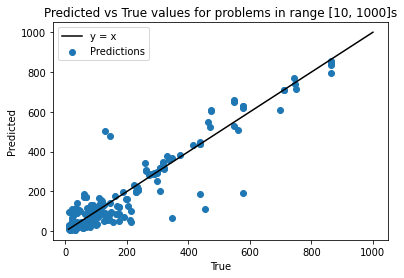

In [29]:
yy_temp = []
predd_temp = []

for i in range(len(yy)):
  yy_final.append(yy[i])
  predd_final.append(predd[i])
  if(yy[i]>=10 and yy[i]<1000):
    yy_temp.append(yy[i])
    predd_temp.append(predd[i])

x = np.linspace(10, 1000, 2000)
y = x
plt.title('Predicted vs True values for problems in range [10, 1000]s')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.plot(x, y, color = 'black')
plt.scatter(yy_temp, predd_temp)
plt.legend(['y = x', 'Predictions'])

In [44]:
shuffled = df_reg0.sample(frac=1).reset_index()

columns_dont_want = ['y', 'index', 'inst.name','type', 'CPLEXStatus']
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
X_modified = X

In [45]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(random_state=0)
X_modified, y = oversample.fit_resample(X_modified, y.astype('int'))
print(X_modified.shape[0])

from imblearn.over_sampling import SMOTE

smote_on_3 = 50
#oversample = SMOTE(sampling_strategy={99999:50000})
#X_modified, y = oversample.fit_resample(X_modified, y)
print(X_modified.shape[0])

tmp = X_modified
tmp['y'] = y
print(tmp.head(60))
tmp = tmp.sample(frac = 1).reset_index()
#y = np.log10(tmp['y']*10)+20
tmp = tmp.dropna()
y = tmp['y']
y = np.log(y + 100)
X_modified = tmp.drop(['y'], axis = 1)

3887
3887
        n     k     m    std.dev    max   y
0    60.0  46.0  30.0  29.867712   99.0   0
1    36.0  34.0   6.0  31.388338  100.0   9
2    18.0  16.0   2.0  18.368773   98.0   0
3    54.0  42.0  18.0  20.131920  148.0   9
4    60.0  56.0  24.0  59.732250  375.0   5
5    66.0  50.0  24.0  26.033638   97.0  12
6    36.0  32.0  16.0  33.466354   99.0   2
7    36.0  31.0  16.0  29.706543  141.0   2
8    36.0  29.0  12.0  32.741253  203.0   3
9    18.0  14.0   4.0  15.166720   62.0   0
10   20.0  18.0   8.0  27.430054   99.0   0
11   36.0  29.0  12.0  19.543358  126.0   0
12   18.0  12.0   6.0  14.669897   94.0   0
13   18.0  17.0   8.0  24.906427   97.0   0
14   36.0  33.0  12.0  40.590904  225.0   5
15  100.0  74.0  50.0  46.961933  211.0  11
16   36.0  23.0  12.0  15.283017   97.0   3
17   36.0  29.0  16.0  19.337603  143.0   0
18   18.0  16.0   8.0  19.700121  146.0   0
19   40.0  32.0   8.0  21.092577  100.0  16
20   22.0  18.0   8.0  19.809536   87.0   0
21   36.0  30.0   4.0 

In [46]:
from keras.models import Sequential
from keras.layers import Dense ,Dropout,BatchNormalization
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import tensorflow as tf
from tensorflow import keras 
from tensorflow.python.ops import math_ops


def custom_activation(x):
    #return K.relu(tensorflow.subtract(x,-1)) - K.relu(tensorflow.subtract(x,3.5))
    return 10*1/(1+K.exp(-x))


get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def make_model():
    model = Sequential()
    
    model.add(Dense(8, input_dim=X_modified.shape[1], activation='relu'))
    #model.add(Dropout(0.25))
    
    model.add(Dense(12, activation = 'relu'))
    model.add(Dropout(0.1))

    model.add(Dense(1, activation = 'relu'))
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

In [47]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc2 = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y, random_state=0, train_size = 0.9)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, train_size = 0.83)


# i in range(X_train.shape[0]):
 # if(y_train.iloc[i] > 10):
  #  y_train.iloc[i] = 11

X_train = sc.fit_transform(X_train)
X_test_copy = X_test
X_test = sc.transform(X_test)
#X_val = sc.transform(X_val)

#y_train = sc2.fit_transform(y_train.values.reshape(-1,1))
#y_test = sc2.transform(y_test.values.reshape(-1,1))

estimator = KerasRegressor(build_fn=make_model, epochs=300, batch_size=64, verbose=1)

#history=estimator.fit(X_train,y_train)
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
  
history = estimator.fit(X_train, y_train, shuffle = True)
#plt.plot(history.history['val_accuracy'])

Epoch 1/300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


55/55 [==============================] - 1s 2ms/step - loss: 18.2046
Epoch 2/300
55/55 [==============================] - 0s 2ms/step - loss: 12.6620
Epoch 3/300
55/55 [==============================] - 0s 2ms/step - loss: 7.2570
Epoch 4/300
55/55 [==============================] - 0s 2ms/step - loss: 4.2729
Epoch 5/300
55/55 [==============================] - 0s 2ms/step - loss: 3.0242
Epoch 6/300
55/55 [==============================] - 0s 2ms/step - loss: 2.4661
Epoch 7/300
55/55 [==============================] - 0s 2ms/step - loss: 2.1325
Epoch 8/300
55/55 [==============================] - 0s 2ms/step - loss: 1.6606
Epoch 9/300
55/55 [==============================] - 0s 2ms/step - loss: 1.5221
Epoch 10/300
55/55 [==============================] - 0s 2ms/step - loss: 1.3705
Epoch 11/300
55/55 [==============================] - 0s 2ms/step - loss: 1.1497
Epoch 12/300
55/55 [==============================] - 0s 2ms/step - loss: 0.9187
Epoch 13/300
55/55 [===========================

7/7 [==============================] - 0s 7ms/step
r_square score:  0.9818191627914524
[4.87519732 4.75359019 4.87519732 4.66343909 4.69134788 4.68213123
 4.70048037 4.75359019 4.8598124  4.82028157 4.71849887 4.74493213
 4.84418709 4.60517019 4.62497281 4.70048037 4.80402104 4.69134788
 4.71849887 4.84418709 4.6443909  4.8598124  4.62497281 4.61512052
 4.63472899 4.66343909 4.61512052 4.76217393 4.7095302  4.63472899
 4.66343909 4.63472899 4.63472899 4.71849887 4.80402104 4.60517019
 4.63472899 4.6443909  4.69134788 4.82028157 4.62497281 4.66343909
 4.75359019 4.75359019 4.6443909  4.62497281 4.66343909 4.60517019
 4.66343909 4.75359019 4.8598124  4.81218436 4.84418709 4.80402104
 4.62497281 4.6443909  4.82028157 4.67282883 4.71849887 4.63472899
 4.68213123 4.77912349 4.60517019 4.63472899 4.80402104 4.81218436
 4.68213123 4.65396035 4.65396035 4.63472899 4.71849887 4.63472899
 4.84418709 4.81218436 4.60517019 4.6443909  4.80402104 4.67282883
 4.71849887 4.80402104 4.81218436 4.644390

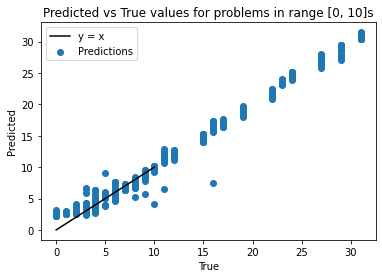

In [49]:
from sklearn.metrics import r2_score
prediction = estimator.predict(X_test)
#y_test = sc2.inverse_transform(y_test.reshape(-1,1))
yy = np.array(y_test)
#yy = np.power(yy, 10)/10
#prediction = sc2.inverse_transform(prediction.reshape(-1,1))
predd = np.array(prediction)
#predd = np.power(predd, 10)/10
print("r_square score: ", r2_score(yy, predd))
print(yy)
yy = np.exp(yy) - 100
predd = np.exp(predd) - 100

from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:")
print(yy)
sqrt(mean_squared_error(yy, predd))

x = np.linspace(0, 10, 100)
y = x
plt.title('Predicted vs True values for problems in range [0, 10]s')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.plot(x,y, color = 'black')
plt.scatter(yy, predd)
plt.legend(['y = x', 'Predictions'])

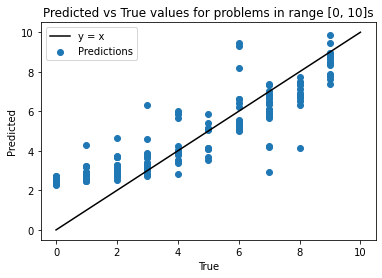

In [35]:
yy_temp = []
predd_temp = []

for i in range(len(yy)):
  yy_final.append(yy[i])
  predd_final.append(predd[i])
  if(yy[i]<10):
    yy_temp.append(yy[i])
    predd_temp.append(predd[i])

x = np.linspace(0, 10, 100)
y = x
plt.title('Predicted vs True values for problems in range [0, 10]s')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.plot(x,y, color = 'black')
plt.scatter(yy_temp, predd_temp)
plt.legend(['y = x', 'Predictions'])

In [36]:
shuffled = df_reg2.sample(frac=1).reset_index()

columns_dont_want = ['y', 'index', 'inst.name','type', 'CPLEXStatus']
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
X_modified = X

In [37]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(random_state=0)
X_modified, y = oversample.fit_resample(X_modified, y.astype('int'))
print(X_modified.shape[0])

from imblearn.over_sampling import SMOTE

smote_on_3 = 50
#oversample = SMOTE(sampling_strategy={99999:50000})
#X_modified, y = oversample.fit_resample(X_modified, y)
print(X_modified.shape[0])

tmp = X_modified
tmp['y'] = y
print(tmp.head(60))
tmp = tmp.sample(frac = 1).reset_index()
#y = np.log10(tmp['y']*10)+20
tmp = tmp.dropna()
y = tmp['y']
X_modified = tmp.drop(['y'], axis = 1)

62016
62016
        n      k   av.length     std.dev      m     y
0   198.0  118.0   96.141411   42.515335   22.0  4510
1   198.0  117.0  101.853539   47.585918   33.0  1005
2   162.0  136.0  650.000000  167.536774   36.0  4510
3   132.0  114.0  325.500000  118.681976   12.0  4510
4   100.0   88.0  415.119995  111.858437   25.0  4510
5   100.0   83.0   96.209999   47.907383   50.0  4510
6   154.0  135.0  620.402588  136.800858   56.0  1323
7    80.0   71.0  331.899994   82.355003    8.0  4510
8   120.0  104.0  466.216675  110.879463   12.0  4510
9    66.0   56.0  262.772736   68.065765    6.0  4510
10   88.0   55.0   99.750000   21.565857    8.0  1478
11  132.0   87.0  105.484848   45.843826   12.0  4510
12  120.0  100.0  482.750000  118.722672   24.0  4510
13  200.0  161.0  492.994995  167.105225   40.0  4510
14  120.0   99.0  288.391663  106.842712   12.0  4510
15  180.0  160.0  703.455566  193.612442   36.0  4510
16  144.0  125.0  362.944458  115.249062   48.0  1100
17  140.0   96.0

In [38]:
from keras.models import Sequential
from keras.layers import Dense ,Dropout,BatchNormalization
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import tensorflow as tf
from tensorflow import keras 
from tensorflow.python.ops import math_ops


def custom_activation(x):
    #return K.relu(tensorflow.subtract(x,-1)) - K.relu(tensorflow.subtract(x,3.5))
    return 4510*1/(1+K.exp(-x))


get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def make_model():
    model = Sequential()
    
    model.add(Dense(16, input_dim=X_modified.shape[1], activation='relu'))
    #model.add(Dropout(0.25))
    
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.1))

    model.add(Dense(16, activation = 'relu'))

    model.add(Dense(4, activation = 'relu'))

    model.add(Dense(1, activation = custom_activation))
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

In [39]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc2 = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y, random_state=0, train_size = 0.9)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, train_size = 0.83)


X_train = sc.fit_transform(X_train)
X_test_copy = X_test
X_test = sc.transform(X_test)
#X_val = sc.transform(X_val)

#y_train = sc2.fit_transform(y_train.values.reshape(-1,1))
#y_test = sc2.transform(y_test.values.reshape(-1,1))

estimator = KerasRegressor(build_fn=make_model, epochs=60, batch_size=128, verbose=1)

#history=estimator.fit(X_train,y_train)
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
  
history = estimator.fit(X_train, y_train, shuffle = True)
#plt.plot(history.history['val_accuracy'])

Epoch 1/60


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


437/437 [==============================] - 2s 2ms/step - loss: 265039.2188
Epoch 2/60
437/437 [==============================] - 1s 2ms/step - loss: 122017.3594
Epoch 3/60
437/437 [==============================] - 1s 2ms/step - loss: 101326.5391
Epoch 4/60
437/437 [==============================] - 1s 2ms/step - loss: 82629.8906
Epoch 5/60
437/437 [==============================] - 1s 2ms/step - loss: 62263.0352
Epoch 6/60
437/437 [==============================] - 1s 2ms/step - loss: 47066.8359
Epoch 7/60
437/437 [==============================] - 1s 2ms/step - loss: 41973.3789
Epoch 8/60
437/437 [==============================] - 1s 2ms/step - loss: 37326.7617
Epoch 9/60
437/437 [==============================] - 1s 2ms/step - loss: 35315.5391
Epoch 10/60
437/437 [==============================] - 1s 2ms/step - loss: 33392.0039
Epoch 11/60
437/437 [==============================] - 1s 2ms/step - loss: 32965.9961
Epoch 12/60
437/437 [==============================] - 1s 2ms/step - lo

In [40]:
from sklearn.metrics import r2_score
prediction = estimator.predict(X_test)
print("r_square score: ", r2_score(y_test,prediction))
#y_test = sc2.inverse_transform(y_test.reshape(-1,1))
yy = np.array(y_test)
#yy = np.power(yy, 10)/10
#prediction = sc2.inverse_transform(prediction.reshape(-1,1))
predd = np.array(prediction)
#predd = np.power(predd, 10)/10

from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:")
sqrt(mean_squared_error(yy, predd))

49/49 [==============================] - 0s 1ms/step
r_square score:  0.9789886827927872
RMSE:


167.8683556476298

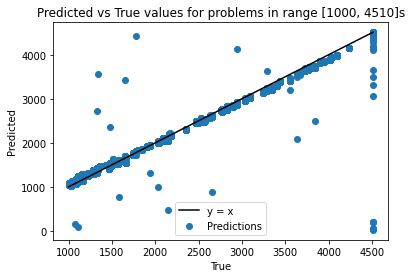

In [41]:
yy_temp = []
predd_temp = []

for i in range(len(yy)):
  yy_final.append(yy[i])
  predd_final.append(predd[i])
  if(yy[i]>1000):
    yy_temp.append(yy[i])
    predd_temp.append(predd[i])

x = np.linspace(1000, 4510, 2000)
y = x

plt.title('Predicted vs True values for problems in range [1000, 4510]s')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.plot(x,y, color = 'black')
plt.scatter(yy_temp, predd_temp)
plt.legend(['y = x', 'Predictions'])

In [42]:
print("r_square score: ", r2_score(yy_final, predd_final))
#y_test = sc2.inverse_transform(y_test.reshape(-1,1))
yy = np.array(yy_final)
#yy = np.power(yy, 10)/10
#prediction = sc2.inverse_transform(prediction.reshape(-1,1))
predd = np.array(predd_final)
#predd = np.power(predd, 10)/10

from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:")
sqrt(mean_squared_error(yy, predd))

r_square score:  0.9802108187409957
RMSE:


167.03411202810943

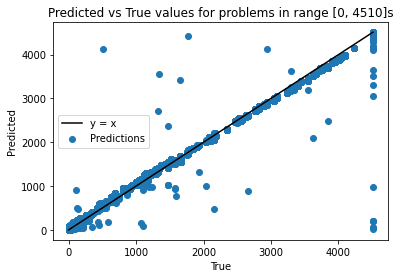

In [43]:
x = np.linspace(0, 4510, 2000)
y = x

plt.title('Predicted vs True values for problems in range [0, 4510]s')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.plot(x,y, color = 'black')
plt.scatter(yy_final, predd_final)
plt.legend(['y = x', 'Predictions'])